In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage.feature import hog
from joblib import load
import numpy as np
import os
import sys
import cv2
from sklearn.cluster import MeanShift
import models

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('device: {}'.format(device))


device: cuda:1


In [2]:
# loading model module

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*8*8, 600)
        self.fc2 = nn.Linear(600, 150)
        self.fc3 = nn.Linear(150, 18)
        self.fc4 = nn.Linear(18, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32*8*8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
net = net.to(device)
net.load_state_dict(torch.load('data/cnn_model.pkl'))
print(net)

logistic_model = models.LogisticRegression(96)
logistic_model.load('data/logistic.pkl')
linear_svm = load('data/linear_SVM.joblib')
sigmoid_svm = load('data/sigmoid_SVM.joblib')

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=2, bias=True)
)


In [3]:
# evaluation functions for different models
# inputs: n*96*96*3
def cnn_evaluation(inputs):
    X = torch.from_numpy(inputs / 255.)
    X = torch.transpose(torch.transpose(X, 1, 3), 2, 3)

    with torch.no_grad():
        X = X.to(device)
        outputs = net(X.float())
        _, predicted = torch.max(outputs.data, 1)
    return predicted

def hog_evalution(inputs, model):
    X = []
    for i in range(len(inputs)):
        feature, _ = hog(inputs[i], 9, (16, 16), (2, 2), visualise=True, feature_vector=True)
        X.append(feature)
    X = np.array(X)
    return model.predict(X)

In [4]:
import matplotlib.pyplot as plt

% matplotlib inline


# remove some too large bounding boxes in res
def reduce_res(res, threshold):
    mask = np.ones(len(res))
    soft = 0.95
    for i in range(len(res)):
        center1, height1, width1 = res[i]
        for j in range(len(res)):
            if j == i or mask[j]==0:
                continue
            center2, height2, width2 = res[j]
            if height1>=height2 and np.sqrt((center1[0]-center2[0])**2+(center1[1]-center2[1])**2)<threshold:
                if center1[0]+width1/2 >center2[0]+soft*width2/2 and center1[0]-width1/2<center2[0]-soft*width2/2 and \
                center1[1]+height1/2>center2[1]+soft*height2/2 and center1[1]-height1/2<center2[1]-soft*height2/2:
                    mask[i] = 0
                    break
    return mask
            

# face detection 

# filename = 'data/2002/09/10/big/img_8075.jpg'
# filename = 'data/2002/08/18/big/img_181.jpg'
# filename = 'data/2003/02/06/big/img_172.jpg'
# filename = 'data/2002/09/03/big/img_14611.jpg'
# filename = 'data/2002/09/03/big/img_14807.jpg'
padding = 500
def detection(filename, model_name):
    origin_img = cv2.imread(filename)
    a, b, _ = origin_img.shape
    stride_x = int(b/40)
    stride_y = int(a/40)
    print('Processing {}'.format(filename))
    
    height_list = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    height_list = height_list*a
    res = []
    
    for height in height_list:
        img = cv2.copyMakeBorder(
                        origin_img, padding, padding, padding, padding, borderType=cv2.BORDER_REPLICATE)

        height = int(height)

        width = int(height / 3 * 2)
        sub_imgs = []
        coordinates = []
        for x in range(0, b, stride_x):
            for y in range(0, a, stride_y):
                center_x = x + padding
                center_y = y + padding
                sub_img = img[int(center_y-height/2):int(center_y+height/2),
                               int(center_x - width/2):int(center_x + width/2)]
                try:
                    sub_img = cv2.resize(sub_img, (96, 96))
                except:
                    continue
                sub_imgs.append(sub_img)
                coordinates.append((center_x, center_y))
        sub_imgs = np.array(sub_imgs)

        # predict the subimg using pretrained model
        if model_name.lower() == 'cnn':
            predicted = cnn_evaluation(sub_imgs).cpu().numpy()
        elif model_name.lower() == 'logistic':
            predicted = hog_evalution(sub_imgs, logistic_model)
        elif model_name.lower() == 'sigmoidsvm':
            predicted = hog_evalution(sub_imgs, sigmoid_svm)
        elif model_name.lower() == 'linearsvm':
            predicted = hog_evalution(sub_imgs, linear_svm)
        else:
            raise ValueError
        print(predicted)
        count = 0
        face_coordinates = []
        for i in range(predicted.shape[0]):
            if predicted[i]>0:
                count += 1
                face_coordinates.append(coordinates[i])

        print('height = {}, face = {}'.format(height, count))
        if count == 0:
            continue
        face_coordinates = np.array(face_coordinates)
        
        clustering = MeanShift(bandwidth=50).fit(face_coordinates)
        print('cluster into {} groups'.format(len(clustering.cluster_centers_)))

        i = 0
        count_class = []
        for x, y in clustering.cluster_centers_:
            count = 0
            count_num = 0
            for j in range(len(face_coordinates)):
                if clustering.labels_[j] == i:
                    count_num += 1
            count_class.append(count_num)
            i+=1

        count_class = np.array(count_class)
        count_class = count_class / np.sum(count_class)
    #     print(count_class)
        for i in range(count_class.shape[0]):
            if count_class[i]>0.3 and count_class[i]*len(clustering.labels_)>2:
                res.append([clustering.cluster_centers_[i], height, width])

    mask = reduce_res(res, a/10)

    origin_img = cv2.copyMakeBorder(
                    origin_img, padding, padding, padding, padding, borderType=cv2.BORDER_REPLICATE)

    for i in range(len(res)):
        if mask[i]==0:
            continue
        center, height, width = res[i]
        cv2.rectangle(origin_img, (int(center[0] - width/2), int(center[1]-height/2)),
                    (int(center[0]+width/2), int(center[1]+height/2)), (0, 0, 255), 2)
    #     cv2.circle(origin_img, (int(center[0]), int(center[1])), radius=5, color=(255, 0, 0))
    origin_img = origin_img[padding:-padding, padding:-padding]
    # cv2.imwrite('data/visual/test1/face_all_01.jpg', origin_img)
    return origin_img


In [5]:
img1 = detection('data/2002/09/03/big/img_14611.jpg', 'cnn')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

Processing data/2002/09/03/big/img_14611.jpg
[0 0 0 ... 0 0 0]
height = 45, face = 10
cluster into 7 groups
[0 0 0 ... 0 0 0]
height = 90, face = 19
cluster into 11 groups
[0 0 0 ... 0 0 0]
height = 135, face = 51
cluster into 12 groups
[0 0 0 ... 0 0 0]
height = 180, face = 38
cluster into 10 groups
[0 0 0 ... 0 0 0]
height = 225, face = 65
cluster into 7 groups
[0 0 0 ... 0 0 0]
height = 270, face = 88
cluster into 4 groups
[0 0 0 ... 0 0 0]
height = 315, face = 128
cluster into 4 groups
[0 0 0 ... 0 0 1]
height = 360, face = 152
cluster into 3 groups


In [6]:
img2 = detection('data/2002/09/03/big/img_14611.jpg', 'logistic')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

Processing data/2002/09/03/big/img_14611.jpg


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 45, face = 14
cluster into 6 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 90, face = 23
cluster into 8 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 135, face = 22
cluster into 7 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 180, face = 26
cluster into 6 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 225, face = 25
cluster into 4 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 270, face = 19
cluster into 2 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 315, face = 27
cluster into 3 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 360, face = 43
cluster into 2 groups


In [7]:
img3 = detection('data/2002/09/03/big/img_14611.jpg', 'sigmoidsvm')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

Processing data/2002/09/03/big/img_14611.jpg


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 45, face = 98
cluster into 19 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 90, face = 97
cluster into 18 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 135, face = 117
cluster into 16 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 180, face = 138
cluster into 16 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 225, face = 135
cluster into 13 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 270, face = 135
cluster into 10 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 315, face = 195
cluster into 6 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 360, face = 259
cluster into 6 groups


In [8]:
img4 = detection('data/2002/09/03/big/img_14611.jpg', 'linearsvm')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

Processing data/2002/09/03/big/img_14611.jpg


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 45, face = 29
cluster into 13 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 90, face = 29
cluster into 9 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 135, face = 36
cluster into 12 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 180, face = 40
cluster into 10 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 225, face = 30
cluster into 7 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 270, face = 32
cluster into 6 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 315, face = 57
cluster into 5 groups


/home/chb/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[-1. -1. -1. ... -1. -1. -1.]
height = 360, face = 103
cluster into 6 groups


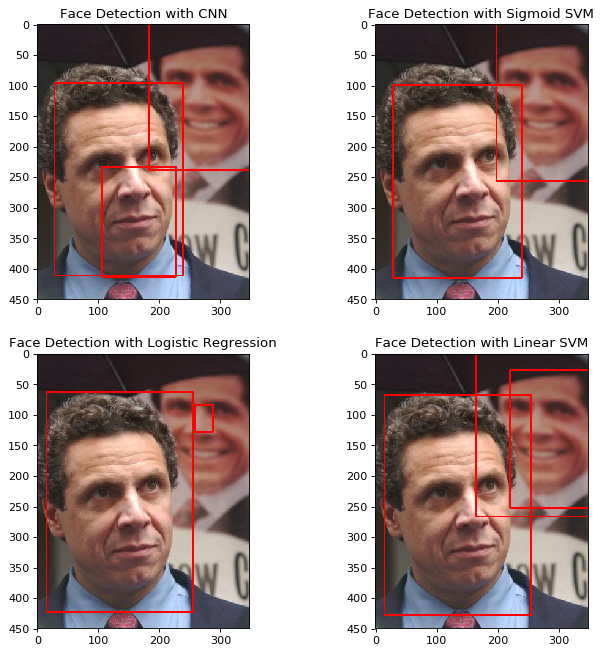

In [10]:

plt.figure('img',figsize=(10,10),dpi=80)
plt.subplot(221)
plt.imshow(img1)
plt.title('Face Detection with CNN')
plt.subplot(223)
plt.imshow(img2)
plt.title('Face Detection with Logistic Regression')
plt.subplot(222)
plt.imshow(img3)
plt.title('Face Detection with Sigmoid SVM')
plt.subplot(224)
plt.imshow(img4)
plt.title('Face Detection with Linear SVM')
plt.savefig('data/visual/report_use/face_detection.jpg')
